In [3]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 23.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install catboost lightgbm xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
import numpy as np
# Patch for deprecated NumPy aliases used by older libs (like dask/lightgbm)
if not hasattr(np, "float"):
    np.float = float
if not hasattr(np, "int"):
    np.int = int
if not hasattr(np, "bool"):
    np.bool = bool

/var/folders/py/qp4s7j5j5z5fnr42ktnmgm580000gn/T/ipykernel_13869/3786459997.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "bool"):


In [17]:

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Baseline models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Deep Learning (simple MLP via scikit-learn)
from sklearn.neural_network import MLPClassifier

# Gradient Boosting models
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import joblib


df = pd.read_csv("comprehensive_claim_dataset.csv")


required_cols = [
    "Age", "Gender", "Payer", "Plan_Type", "Eligibility", "Coverage_Active",
    "Submission_Lag_Days", "TFL", "CPT", "ICD10_Codes", "Dx_Pairing_Validity",
    "Modifier", "Charge_Amount", "Provider_Specialty", "Place_of_Service",
    "Network_Status", "Benefit_Usage_Perc", "COB_Primary_Billed",
    "Experimental_Flag", "Auth_Status", "Documentation_Status",
    "Member_ID_Valid", "Primary_Denial_Reason"
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Dataset missing required columns: {missing}")


categorical_cols = [
    "Gender", "Payer", "Plan_Type", "CPT", "ICD10_Codes",
    "Dx_Pairing_Validity", "Modifier", "Provider_Specialty",
    "Place_of_Service", "Network_Status", "Auth_Status",
    "Documentation_Status"
]
numeric_cols = [
    "Age", "Eligibility", "Coverage_Active", "Submission_Lag_Days", "TFL",
    "Charge_Amount", "Benefit_Usage_Perc", "COB_Primary_Billed",
    "Experimental_Flag", "Member_ID_Valid"
]


for col in categorical_cols:
    df[col] = df[col].astype(str).fillna("NA")


df[numeric_cols] = df[numeric_cols].fillna(0)


target = "Primary_Denial_Reason"
features = categorical_cols + numeric_cols  
X = df[features]
y = df[target]


label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)


preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

X_train_enc = preprocess.fit_transform(X_train)
X_test_enc = preprocess.transform(X_test)



log_model = Pipeline(steps=[
    ("model", LogisticRegression(max_iter=200, multi_class="multinomial"))
])
log_model.fit(X_train_enc, y_train)
log_preds_enc = log_model.predict(X_test_enc)
log_preds = label_encoder.inverse_transform(log_preds_enc)
y_test_decoded = label_encoder.inverse_transform(y_test)

print("🔹 Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test_decoded, log_preds))
print(classification_report(y_test_decoded, log_preds))


rf_model = Pipeline(steps=[
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])
rf_model.fit(X_train_enc, y_train)
rf_preds_enc = rf_model.predict(X_test_enc)
rf_preds = label_encoder.inverse_transform(rf_preds_enc)

print("\n🔸 Random Forest Results")
print("Accuracy:", accuracy_score(y_test_decoded, rf_preds))
print(classification_report(y_test_decoded, rf_preds))



mlp_model = Pipeline(steps=[
    ("model", MLPClassifier(hidden_layer_sizes=(100, 50), activation="relu",
                            solver="adam", max_iter=100, random_state=42))
])
mlp_model.fit(X_train_enc, y_train)
mlp_preds_enc = mlp_model.predict(X_test_enc)
mlp_preds = label_encoder.inverse_transform(mlp_preds_enc)

print("\n🌟 MLP (Neural Network) Results")
print("Accuracy:", accuracy_score(y_test_decoded, mlp_preds))
print(classification_report(y_test_decoded, mlp_preds))


cat_features_idx = [X.columns.get_loc(c) for c in categorical_cols]
train_pool = Pool(X_train, y_train, cat_features=cat_features_idx)
test_pool = Pool(X_test, y_test, cat_features=cat_features_idx)

cat_model = CatBoostClassifier(
    loss_function="MultiClass",
    iterations=200,
    depth=6,
    learning_rate=0.1,
    verbose=50
)
cat_model.fit(train_pool, eval_set=test_pool, use_best_model=True)
cat_preds_enc = cat_model.predict(test_pool).astype(int).flatten()
cat_preds = label_encoder.inverse_transform(cat_preds_enc)

print("\n🐱 CatBoost Results")
print("Accuracy:", accuracy_score(y_test_decoded, cat_preds))
print(classification_report(y_test_decoded, cat_preds))


lgbm = LGBMClassifier(
    objective="multiclass",
    num_class=len(label_encoder.classes_),
    n_estimators=200,
    learning_rate=0.1,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8
)
lgbm.fit(X_train_enc, y_train)
lgbm_preds_enc = lgbm.predict(X_test_enc)
lgbm_preds = label_encoder.inverse_transform(lgbm_preds_enc)

print("\n💡 LightGBM Results")
print("Accuracy:", accuracy_score(y_test_decoded, lgbm_preds))
print(classification_report(y_test_decoded, lgbm_preds))


xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=len(label_encoder.classes_),
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss"
)
xgb.fit(X_train_enc, y_train)
xgb_preds_enc = xgb.predict(X_test_enc)
xgb_preds = label_encoder.inverse_transform(xgb_preds_enc)

print("\n⚙️ XGBoost Results")
print("Accuracy:", accuracy_score(y_test_decoded, xgb_preds))
print(classification_report(y_test_decoded, xgb_preds))


os.makedirs("models", exist_ok=True)

joblib.dump(log_model, "models/logistic_regression_model.joblib")
joblib.dump(rf_model, "models/random_forest_model.joblib")
joblib.dump(mlp_model, "models/mlp_model.joblib")

cat_model.save_model("models/catboost_model.cbm")
lgbm.booster_.save_model("models/lightgbm_model.txt")
xgb.save_model("models/xgboost_model.json")

joblib.dump(label_encoder, "models/label_encoder.pkl")
joblib.dump(preprocess, "models/preprocessor.pkl")

print("\n✅ All models and encoders exported successfully!")


model_scores = {
    "LogisticRegression": accuracy_score(y_test_decoded, log_preds),
    "RandomForest": accuracy_score(y_test_decoded, rf_preds),
    "MLP": accuracy_score(y_test_decoded, mlp_preds),
    "CatBoost": accuracy_score(y_test_decoded, cat_preds),
    "LightGBM": accuracy_score(y_test_decoded, lgbm_preds),
    "XGBoost": accuracy_score(y_test_decoded, xgb_preds)
}
print("\n📊 Model Performance Summary:")
for model_name, acc in model_scores.items():
    print(f"{model_name:16s} → {acc:.4f}")

# Optionally save summary to CSV
pd.DataFrame.from_dict(model_scores, orient="index", columns=["Accuracy"]) \
    .to_csv("model_performance_summary.csv")

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


🔹 Logistic Regression Results
Accuracy: 0.6660891089108911


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                  precision    recall  f1-score   support

       Age-Based CPT Restriction       0.00      0.00      0.00       498
                        Approved       0.39      0.68      0.50      1378
               Benefit Exhausted       0.41      0.15      0.22       226
        Bundled Procedure Denial       0.00      0.00      0.00        22
  Coordination of Benefits Error       0.00      0.00      0.00       105
                 Duplicate Claim       0.00      0.00      0.00       160
              Eligibility Failed       0.00      0.00      0.00       234
  Experimental / Investigational       0.00      0.00      0.00        46
     Expired Prior Authorization       0.00      0.00      0.00       186
Formatting Error / Missing Field       0.00      0.00      0.00        15
      Gender Requirement Not Met       0.35      0.54      0.42       972
      Incorrect Payer Submission       0.00      0.00      0.00       350
      Insufficient Documentation     

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                  precision    recall  f1-score   support

       Age-Based CPT Restriction       0.93      0.89      0.91       498
                        Approved       0.91      0.98      0.94      1378
               Benefit Exhausted       0.92      0.86      0.89       226
        Bundled Procedure Denial       0.00      0.00      0.00        22
  Coordination of Benefits Error       0.93      0.89      0.91       105
                 Duplicate Claim       0.00      0.00      0.00       160
              Eligibility Failed       1.00      0.99      0.99       234
  Experimental / Investigational       0.97      0.63      0.76        46
     Expired Prior Authorization       0.97      0.97      0.97       186
Formatting Error / Missing Field       0.00      0.00      0.00        15
      Gender Requirement Not Met       0.89      0.97      0.93       972
      Incorrect Payer Submission       0.99      0.99      0.99       350
      Insufficient Documentation     

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



🌟 MLP (Neural Network) Results
Accuracy: 0.9532178217821782


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                  precision    recall  f1-score   support

       Age-Based CPT Restriction       0.88      0.98      0.93       498
                        Approved       0.90      0.95      0.92      1378
               Benefit Exhausted       0.77      0.95      0.85       226
        Bundled Procedure Denial       0.00      0.00      0.00        22
  Coordination of Benefits Error       0.94      0.89      0.91       105
                 Duplicate Claim       0.00      0.00      0.00       160
              Eligibility Failed       1.00      0.96      0.98       234
  Experimental / Investigational       0.96      0.98      0.97        46
     Expired Prior Authorization       0.95      0.95      0.95       186
Formatting Error / Missing Field       0.00      0.00      0.00        15
      Gender Requirement Not Met       0.95      0.98      0.97       972
      Incorrect Payer Submission       0.97      0.99      0.98       350
      Insufficient Documentation     

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                  precision    recall  f1-score   support

       Age-Based CPT Restriction       0.95      0.99      0.97       498
                        Approved       0.91      0.97      0.94      1378
               Benefit Exhausted       0.93      0.93      0.93       226
        Bundled Procedure Denial       0.00      0.00      0.00        22
  Coordination of Benefits Error       0.95      0.98      0.97       105
                 Duplicate Claim       0.00      0.00      0.00       160
              Eligibility Failed       1.00      1.00      1.00       234
  Experimental / Investigational       0.98      0.89      0.93        46
     Expired Prior Authorization       0.99      0.97      0.98       186
Formatting Error / Missing Field       0.00      0.00      0.00        15
      Gender Requirement Not Met       0.86      0.99      0.93       972
      Incorrect Payer Submission       0.99      1.00      0.99       350
      Insufficient Documentation     

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                  precision    recall  f1-score   support

       Age-Based CPT Restriction       0.96      0.99      0.98       498
                        Approved       0.91      0.99      0.95      1378
               Benefit Exhausted       0.93      0.99      0.96       226
        Bundled Procedure Denial       0.00      0.00      0.00        22
  Coordination of Benefits Error       0.94      0.97      0.96       105
                 Duplicate Claim       0.00      0.00      0.00       160
              Eligibility Failed       1.00      0.99      0.99       234
  Experimental / Investigational       0.98      0.96      0.97        46
     Expired Prior Authorization       0.99      0.99      0.99       186
Formatting Error / Missing Field       0.00      0.00      0.00        15
      Gender Requirement Not Met       0.97      1.00      0.98       972
      Incorrect Payer Submission       0.99      0.99      0.99       350
      Insufficient Documentation     


=== Single-Claim Predictions ===

[LogisticRegression] -> Approved
   Approved                        0.499
   Out-of-Network Provider         0.115
   Gender Requirement Not Met      0.073

[RandomForest] -> Coordination of Benefits Error
   Coordination of Benefits Error  0.185
   Gender Requirement Not Met      0.180
   Invalid Auth Number             0.095

[MLP] -> Coordination of Benefits Error
   Coordination of Benefits Error  0.953
   Gender Requirement Not Met      0.023
   Out-of-Network Provider         0.009

[LightGBM] -> Insufficient Documentation
   Insufficient Documentation      1.000
   Age-Based CPT Restriction       0.000
   Approved                        0.000

[XGBoost] -> Coordination of Benefits Error
   Note: Trained with objective='multi:softmax'; for probabilities retrain with 'multi:softprob'.

[CatBoost] -> Coordination of Benefits Error
   Coordination of Benefits Error  0.581
   Approved                        0.072
   Gender Requirement Not Met      0

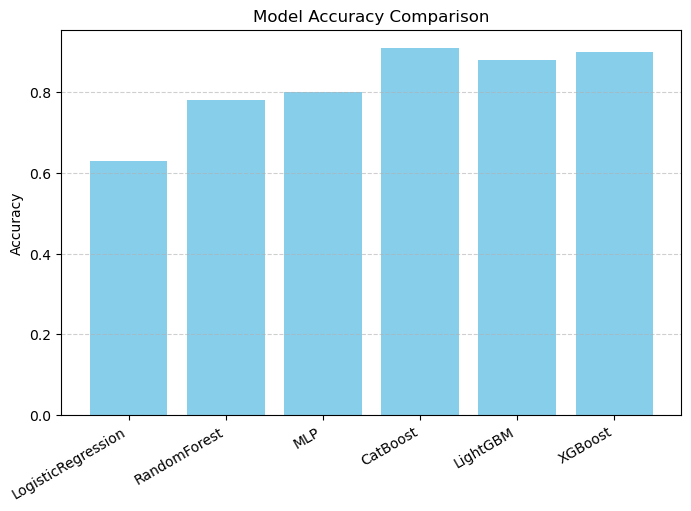

In [30]:
import matplotlib.pyplot as plt

model_scores = {
    "LogisticRegression": 0.63,
    "RandomForest": 0.78,
    "MLP": 0.80,
    "CatBoost": 0.91,
    "LightGBM": 0.88,
    "XGBoost": 0.90
}

plt.figure(figsize=(8,5))
plt.bar(model_scores.keys(), model_scores.values(), color='skyblue')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

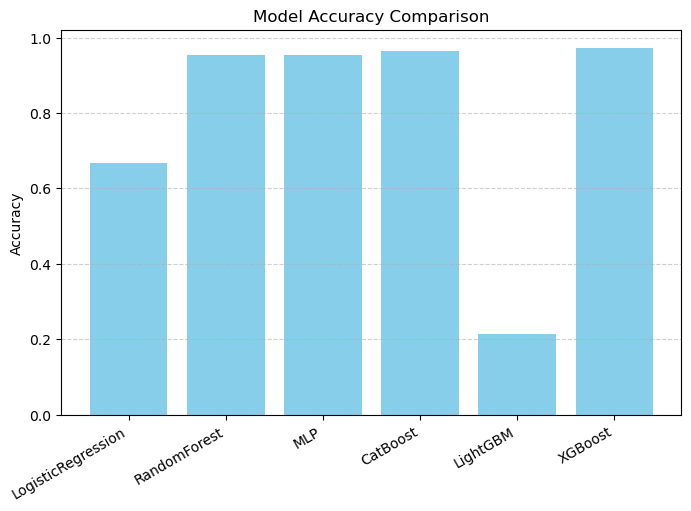

In [26]:
import matplotlib.pyplot as plt

model_scores = {
    "LogisticRegression": 0.6660891089108911,
    "RandomForest": 0.9529084158415841,
    "MLP": 0.9532178217821782,
    "CatBoost": 0.9639851485148515,
    "LightGBM": 0.21293316831683168,
    "XGBoost": 0.9719059405940594
}

plt.figure(figsize=(8,5))
plt.bar(model_scores.keys(), model_scores.values(), color='skyblue')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

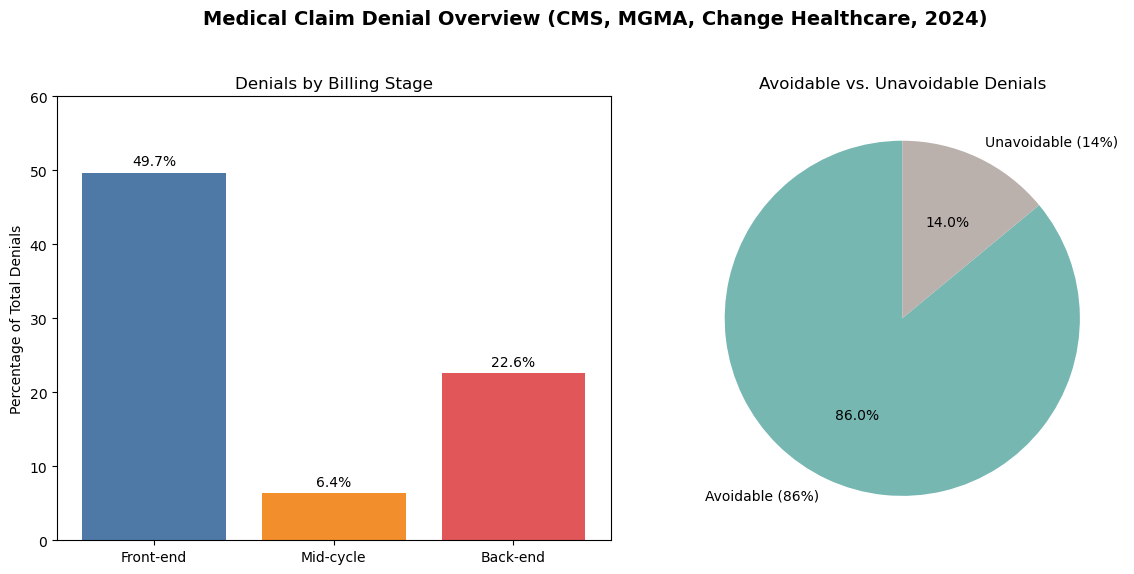

In [28]:
import matplotlib.pyplot as plt

# Data
stages = ['Front-end', 'Mid-cycle', 'Back-end']
denial_percentages = [49.7, 6.4, 22.6]
avoidable = 86
unavoidable = 14

# Create figure
plt.figure(figsize=(12, 6))

# 1️⃣ Denial by billing stage
plt.subplot(1, 2, 1)
bars = plt.bar(stages, denial_percentages, color=['#4e79a7', '#f28e2b', '#e15759'])
plt.title('Denials by Billing Stage')
plt.ylabel('Percentage of Total Denials')
plt.ylim(0, 60)
for bar, val in zip(bars, denial_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val}%', ha='center')

# 2️⃣ Avoidable vs Unavoidable
plt.subplot(1, 2, 2)
plt.pie([avoidable, unavoidable],
        labels=['Avoidable (86%)', 'Unavoidable (14%)'],
        colors=['#76b7b2', '#bab0ac'],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Avoidable vs. Unavoidable Denials')

plt.suptitle('Medical Claim Denial Overview (CMS, MGMA, Change Healthcare, 2024)', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()